# Python Lab 03b: Discriminant Analysis e Riduzione di Dimensionalità per il Dataset LFW
## Francesco Della Santa, Matematica per l'Intelligenza Artificiale, Politecnico di Torino

In [1]:
# ***** NOTA BENE! *****
# perché %matplotlib widget funzioni, installare nell'ambiente virtuale 
# il pacchetto ipympl con il comando:
# pip install ipympl
#
# ATTENZIONE: perché funzioni è necessario chiudere e rilanciare jupyter-lab
#
# STILE DI VISUALIZZAZIONE PLOT FATTI CON MATPLOTLIB
%matplotlib widget
#
#
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from FisherDA import MultipleFisherDiscriminantAnalysis as MDA

# Importazione del Dataset “Labeled Faces in the Wild”

Il dataset in questione è disponibile tramite il sottomodulo "datasets" di scikit-learn (come il dataset iris, wine e molti altri) e la funzione fetch_lfw_people. Documentazione completa della funzione qui: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people

Il dataset caricato dalla funzione restituisce (ormai vecchie) immagini di volti famosi.
L'oggetto restituito è della classe "Bunch" di scikit-learn, dal funzionamento simile ai dizionari (per come lo utilizzeremo, potrebbe essere di fatto un dizionario).

In [2]:
# Il codice presente in questa cella serve nel caso si verifichi un errore del tipo
#
# "URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1124)>"
#
# al momento di chiamare la funzione fetch_lfw_people di sklearn.datasets
#
# ATTENZIONE: il codice di questa cella non è quindi sempre necessario; se quindi non lo fosse, commentarlo pure.
#

import os, ssl

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

## Importazione di parte del dataset e prime ispezioni del contenuto

Di seguito importiamo parte del dataset, stampiamo la descrizione ufficiale fornita da scikit-learn ed esploriamo un po' il contenuto.

### Importazione e Stampa Descrizione

In [3]:
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

print(lfw_people['DESCR'])

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenCV li

### Visualizzazioni "Esplorative"

Prima di tutto, per comodità, salviamo in variabili apposite i dati contenuti nel simil-dizionario.

In [5]:
face_data = lfw_people['data']
face_images = lfw_people['images']
face_tnames = lfw_people['target_names']
face_targets = lfw_people['target']


Per praticità, creiamoci dei DataFrame di lavoro

In [6]:
# DataFrame delle immagini rappresentate come vettori
face_data_df = pd.DataFrame(face_data)

# DataFrame delle classi di appartenenza e dei nomi
face_targets_df = pd.DataFrame({'target': face_targets, 'target_names': [face_tnames[t] for t in face_targets]})

In [7]:
face_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
0,0.997386,0.996078,0.992157,0.966013,0.758170,0.569935,0.700654,0.794771,0.784314,0.767320,...,0.437909,0.426144,0.422222,0.415686,0.401307,0.393464,0.390850,0.381699,0.388235,0.380392
1,0.147712,0.197386,0.175163,0.192157,0.385621,0.473203,0.543791,0.615686,0.671895,0.694118,...,0.168627,0.239216,0.296732,0.307190,0.325490,0.410458,0.487582,0.457516,0.444444,0.535948
2,0.343791,0.394771,0.491503,0.555556,0.597386,0.611765,0.606536,0.626144,0.640523,0.652288,...,0.483660,0.430065,0.379085,0.410458,0.498039,0.448366,0.481046,0.709804,0.721569,0.716340
3,0.047059,0.016993,0.023529,0.016993,0.031373,0.230065,0.677124,0.667974,0.641830,0.400000,...,0.481046,0.749020,0.903268,0.915033,0.918954,0.925490,0.513725,0.065359,0.142484,0.201307
4,0.471895,0.458824,0.486275,0.499346,0.494118,0.513726,0.545098,0.543791,0.560784,0.581699,...,0.107190,0.062745,0.019608,0.018301,0.018301,0.039216,0.036601,0.078431,0.250980,0.278431


In [8]:
face_targets_df

,target,target_names
0,5,Hugo Chavez
1,6,Tony Blair
2,3,George W Bush
3,1,Colin Powell
4,0,Ariel Sharon
...,...,...
1283,4,Gerhard Schroeder
1284,5,Hugo Chavez
1285,5,Hugo Chavez
1286,3,George W Bush


Vediamo la distribuzione dei volti all'interno del dataset.
 

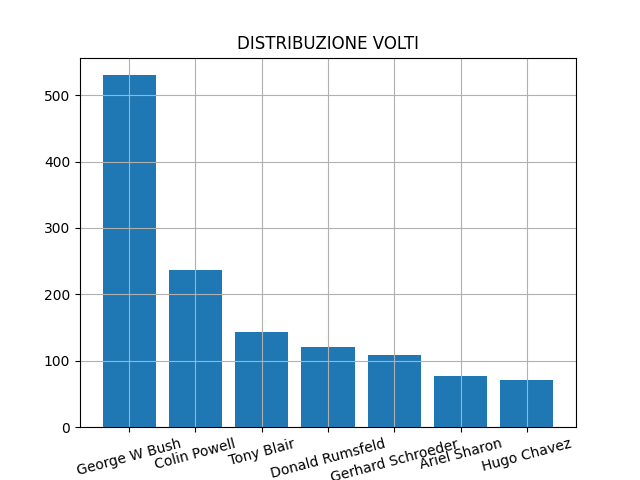

In [9]:
# Definire face_counts sfruttando il metodo "value_counts" delle Serie rispetto alla 
# colonna 'target_names' di face_targets_df
face_counts = face_targets_df['target_names'].value_counts()

plt.figure()
plt.bar(np.arange(len(face_counts.values)), face_counts.values)
plt.xticks(ticks=np.arange(len(face_counts.values)), 
           labels=face_counts.index.to_list(),
           rotation=15)
plt.title('DISTRIBUZIONE VOLTI')
plt.grid()
plt.show()

Visualizziamo alcuni dei volti, sia come immagine che come vettore.

In [10]:
# Raccogliamo gli indici corrispondenti alle varie classi in un dizionario

class_indices = {}

for name in face_tnames:
    class_indices[name] = face_targets_df.loc[face_targets_df['target_names']==name].index.to_list()

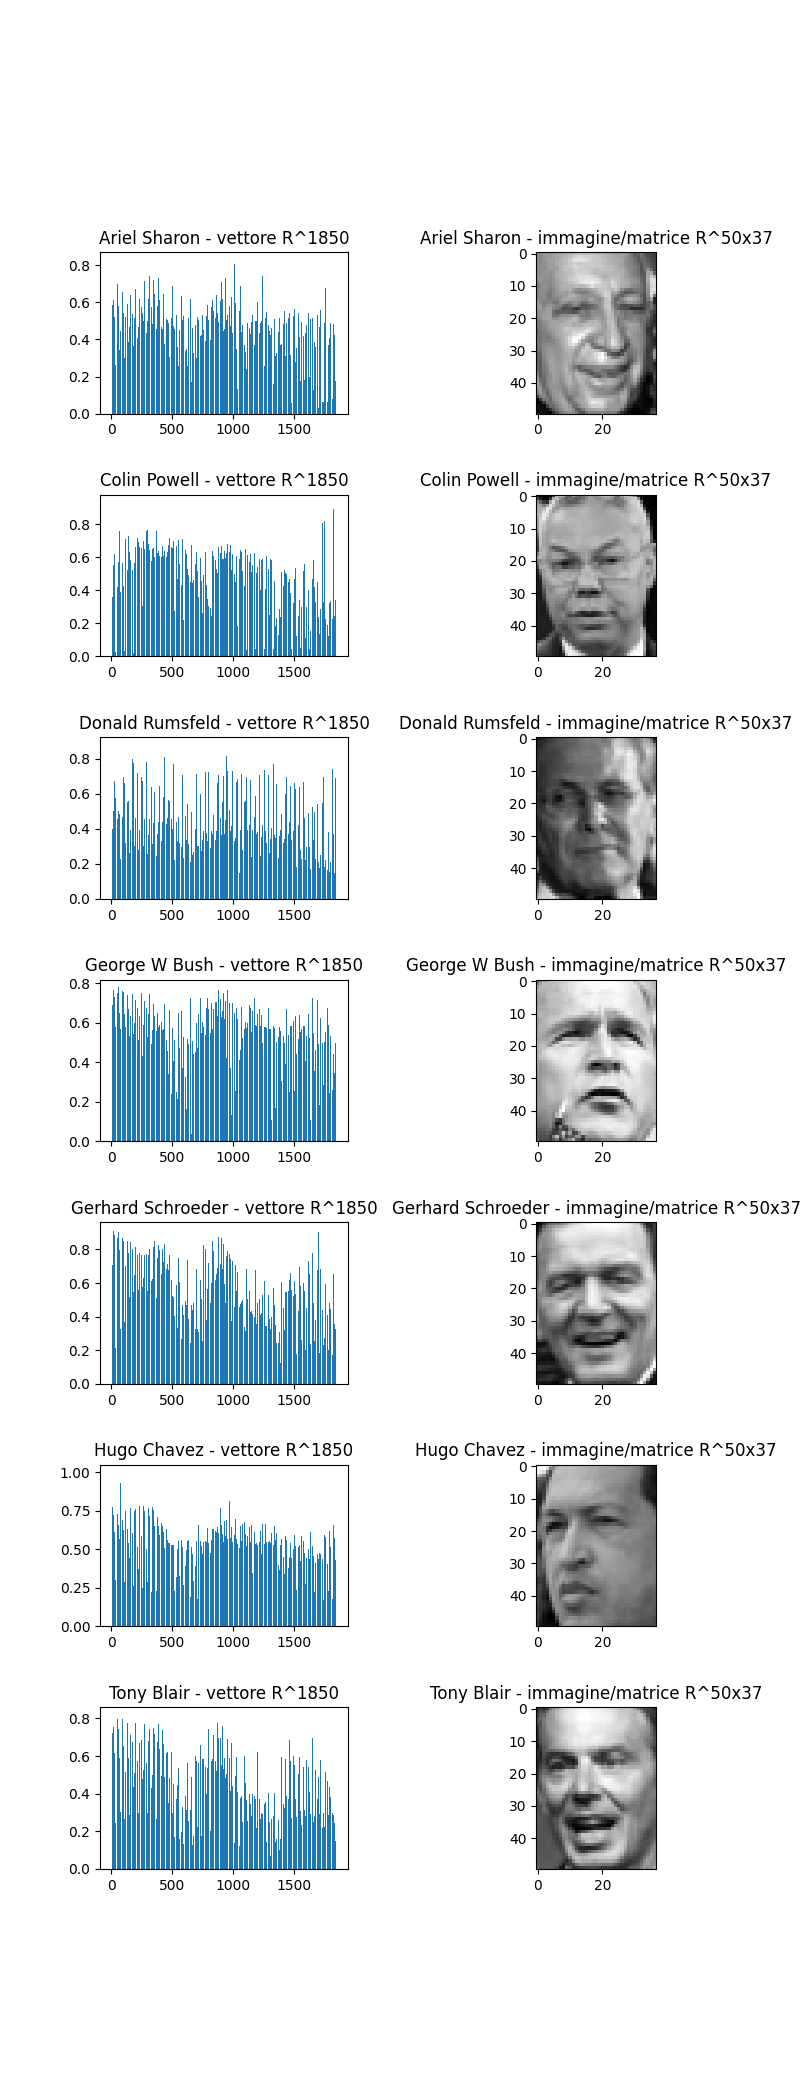

In [11]:
# Visualizziamo il primo dato per ogni classe

fig1, axs1 = plt.subplots(len(face_tnames), 2, figsize=(8, len(face_tnames) * 3))

for i in range(len(face_tnames)):
    
    name = face_tnames[i]
    first_ind = class_indices[name][0]
    
    axs1[i, 0].bar(np.arange(face_data.shape[1]), face_data[first_ind, :])
    axs1[i, 0].set_title('{} - vettore R^{}'.format(name, face_data.shape[1]))
    
    axs1[i, 1].imshow(face_images[first_ind], cmap=plt.cm.gray)
    axs1[i, 1].set_title('{} - immagine/matrice R^{}x{}'.format(name, face_images.shape[1], face_images.shape[2]))

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

## LDA ed FDA per Volti

Applichiamo la LDA al nostro dataset di volti per definire un modello di classificazione. Usiamo poi sia la LDA che la FDA per visualizzare in $\mathbb{R}^3$ i dati.

**ESERCIZIO:** Completa il codice delle celle seguenti generalizzando al dataset dei volti il codice visto in precedenza per la LDA applicata ai vini. Dividi i dati in training e test set.

In [12]:
random_seed = 20240411  # Random seed caratterizzante la suddivisione in training e test set
test_p = 0.45  # Percentuale di dati da utilizzare come test set

X_train, X_test, y_train, y_test = train_test_split(face_data, face_targets, test_size=test_p, random_state=random_seed, shuffle=True)

In [15]:
# Inizializzazione oggetto LDA
lda = LDA()

# "Addestramento" dell'oggetto LDA rispetto a X_train e y_train
lda.fit(X_train, y_train)

# Calcoliamo il vettore delle classi predette rispetto ai dati del test set
y_pred = lda.predict(X_test)
# Calcoliamo la matrice che, per ogni riga, nella colonna j indica la probabilità di appartenenza alla classe (j-1) 
y_pred_proba = lda.predict_proba(X_test)

# Creiamo un DataFrame (solo per estetica) da y_pred e y_pred_proba
y_pred_df = pd.DataFrame({'Pred. Class': y_pred, 
                          'P(Class 0) - %': np.round(y_pred_proba[:, 0] * 100, decimals=2), 
                          'P(Class 1) - %': np.round(y_pred_proba[:, 1] * 100, decimals=2), 
                          'P(Class 2) - %': np.round(y_pred_proba[:, 2] * 100, decimals=2),
                          'P(Class 3) - %': np.round(y_pred_proba[:, 3] * 100, decimals=2),
                          'P(Class 4) - %': np.round(y_pred_proba[:, 4] * 100, decimals=2),
                          'P(Class 5) - %': np.round(y_pred_proba[:, 5] * 100, decimals=2),
                          'P(Class 6) - %': np.round(y_pred_proba[:, 6] * 100, decimals=2)
                         }
                        )

# Calcoliamo l'accuratezza della predizione sul training e sul test set e creiamo un apposito DataFrame (solo per estetica)
scores_dict = {'Training Set': np.round(lda.score(X_train, y_train) * 100, decimals=2), 'Test Set': np.round(lda.score(X_test, y_test) * 100, decimals=2)}
scores = pd.DataFrame(scores_dict, index=['Accuracy'])

display(scores)

display(y_pred_df)

,Training Set,Test Set
Accuracy,99.58,75.17


,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %,P(Class 5) - %,P(Class 6) - %
0,3,0.0,0.000000,0.00,100.000000,0.0,0.0,0.0
1,6,0.0,0.000000,0.00,0.000000,0.0,0.0,100.0
2,1,0.0,100.000000,0.00,0.000000,0.0,0.0,0.0
3,1,0.0,99.790001,0.00,0.000000,0.0,0.0,0.2
4,5,0.0,0.000000,0.00,0.000000,0.0,100.0,0.0
...,...,...,...,...,...,...,...,...
575,6,0.0,0.000000,0.00,0.000000,0.0,0.0,100.0
576,3,0.0,0.010000,0.43,99.559998,0.0,0.0,0.0
577,0,100.0,0.000000,0.00,0.000000,0.0,0.0,0.0
578,1,0.0,99.980003,0.02,0.000000,0.0,0.0,0.0


### Confronto Rappresentazione 3D tra LDA, FDA e PCA

Vediamo la differenza tra LDA e FDA nel proiettare su $\mathbb{R}^3$ i dati.

**Esercizio:** Completare il codice nella cella seguente ed osserva i risultati. Prova a capire perché la MDA non dà buoni risultati.

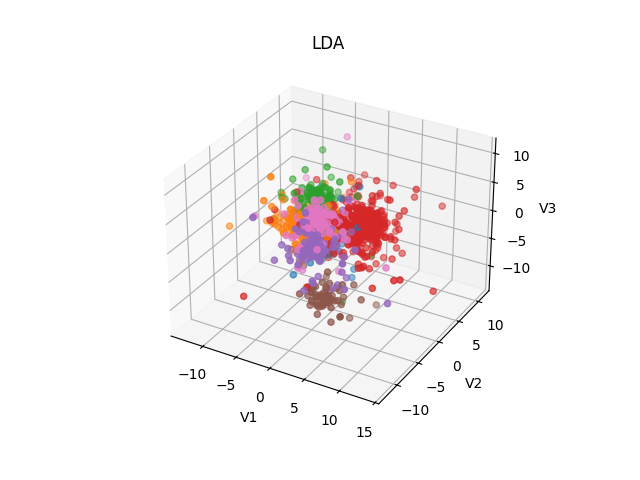

C:\Users\andre\Desktop\POLI\ANNO 3\matematica AI\mia_env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\andre\Desktop\POLI\ANNO 3\matematica AI\mia_env\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\andre\Desktop\POLI\ANNO 3\matematica AI\mia_env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\andre\Desktop\POLI\ANNO 3\matematica AI\mia_env\Lib\site-packages\matplotlib\collections.py:558: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asanyarray(self.convert_xunits(offsets[:, 0]), float),
C:\Users\andre\Desktop\POLI\ANNO 3\matematica AI\mia_env\Lib\site-packages\matplotlib\collections.py:559: ComplexWarning: Cas

ValueError: Invalid RGBA argument: masked_array(data=[0.54901961+0.j, 0.3372549 +0.j, 0.29411765+0.j,
                   0.3       +0.j],
             mask=False,
       fill_value=(1e+20+0j))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [16]:
# Preparazione MDA (per correttezza fatta solo rispetto il training set, come LDA)
mda = MDA(n_dimensions=3)  # Per la proiezione su 3 dimensioni
mda.fit(X_train, y_train)

# Calcolo dei dati in R^2 rispetto LDA, FDA e PCA
Zlda = lda.transform(face_data)
Zmda = mda.transform(face_data)

colmap = matplotlib.cm.tab10.colors

fig_LDA = plt.figure()
ax_lda = fig_LDA.add_subplot(111, projection='3d')
ax_lda.scatter(Zlda[:, 0], Zlda[:, 1], Zlda[:, 2], c=[colmap[fc] for fc in face_targets])
plt.title('LDA')
ax_lda.set_xlabel('V1')
ax_lda.set_ylabel('V2')
ax_lda.set_zlabel('V3')
plt.grid()
plt.show()


fig_MDA = plt.figure()
ax_mda = fig_MDA.add_subplot(111, projection='3d')
ax_mda.scatter(Zmda[:, 0], Zmda[:, 1], Zmda[:, 2], c=[colmap[fc] for fc in face_targets])
plt.title('MDA')
ax_mda.set_xlabel('V1')
ax_mda.set_ylabel('V2')
ax_mda.set_zlabel('V3')
plt.grid()
plt.show()

## QDA per Volti

Applichiamo adesso anceh la QDA al nostro dataset di volti per definire un modello di classificazione.

**ESERCIZIO:** Completa il codice delle celle seguenti generalizzando quando fatto in precedenza in questo stesso laboratorio. Che fenomeno possiamo osservare?

In [18]:
# Inizializzazione oggetto QDA
qda = QDA()

# "Addestramento" dell'oggetto QDA rispetto a X_train e y_train
qda.fit(X_train, y_train)

# Calcoliamo il vettore delle classi predette rispetto ai dati del test set
y_pred_q = qda.predict(X_test)
# Calcoliamo la matrice che, per ogni riga, nella colonna j indica la probabilità di appartenenza alla classe (j-1) 
y_pred_proba_q = qda.predict_proba(X_test)

# Creiamo un DataFrame (solo per estetica) da y_pred e y_pred_proba
y_pred_df_q = pd.DataFrame({'Pred. Class': y_pred_q, 
                          'P(Class 0) - %': np.round(y_pred_proba_q[:, 0] * 100, decimals=2), 
                          'P(Class 1) - %': np.round(y_pred_proba_q[:, 1] * 100, decimals=2), 
                          'P(Class 2) - %': np.round(y_pred_proba_q[:, 2] * 100, decimals=2),
                          'P(Class 3) - %': np.round(y_pred_proba_q[:, 3] * 100, decimals=2),
                          'P(Class 4) - %': np.round(y_pred_proba_q[:, 4] * 100, decimals=2),
                          'P(Class 5) - %': np.round(y_pred_proba_q[:, 5] * 100, decimals=2),
                          'P(Class 6) - %': np.round(y_pred_proba_q[:, 6] * 100, decimals=2)
                         }
                        )

# Calcoliamo l'accuratezza della predizione sul training e sul test set e creiamo un apposito DataFrame (solo per estetica)
scores_dict_q = {'Training Set': qda.score(X_train, y_train), 'Test Set': np.round(qda.score(X_test, y_test) * 100, decimals=2)}
scores_q = pd.DataFrame(scores_dict_q, index=['Accuracy'])

display(scores_q)

display(y_pred_df_q)

C:\Users\andre\Desktop\POLI\ANNO 3\matematica AI\mia_env\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Training Set,Test Set
Accuracy,0.998588,25.86


,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %,P(Class 5) - %,P(Class 6) - %
0,5,0.0,0.0,0.0,0.0,0.0,100.0,0.0
1,2,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,3,0.0,0.0,0.0,100.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
575,3,0.0,0.0,0.0,100.0,0.0,0.0,0.0
576,1,0.0,100.0,0.0,0.0,0.0,0.0,0.0
577,3,0.0,0.0,0.0,100.0,0.0,0.0,0.0
578,2,0.0,0.0,100.0,0.0,0.0,0.0,0.0
